In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pima-indians-diabetes-database/diabetes.csv


# Diabetes Prediction using Machine Learning | Pima Dataset


## Problem Definition

#### The objective of this project is to predict whether a patient has diabetes based on clinical and demographic features. This is a binary classification problem in a healthcare context.

## Dataset Overview

* Dataset: Pima Indians Diabetes Database (UCI / Kaggle)
* Observations (rows): 768
* Features (columns): 8 input features + 1 target variable
* Data type: Structured tabular data
* Domain: Healthcare / Medical Analytics


## Target Variable

* Target column: Outcome
* Meaning:
  
      * 0 → Patient does not have diabetes
      * 1 → Patient has diabetes
#### * Learning task: *Binary classification*

### This target variable clearly defines the supervised learning objective for the machine learning models used later in this notebook.

In [2]:
# =========================================================
# Step 1: Load the Pima Indians Diabetes Dataset
# =========================================================

# Define dataset path (Kaggle input directory)
DATA_PATH = "/kaggle/input/pima-indians-diabetes-database/diabetes.csv"

# Load dataset into a pandas DataFrame
df = pd.read_csv(DATA_PATH)

# Basic confirmation checks
print("Dataset loaded successfully!")
print("Shape of dataset:", df.shape)

# Preview first 5 rows
df.head()


Dataset loaded successfully!
Shape of dataset: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
# =========================================================
# Step 2: Understand Dataset Structure & Columns
# =========================================================

# Display column names
print("Column Names:")
for col in df.columns:
    print("-", col)

print("\nData Types:")
df.dtypes


Column Names:
- Pregnancies
- Glucose
- BloodPressure
- SkinThickness
- Insulin
- BMI
- DiabetesPedigreeFunction
- Age
- Outcome

Data Types:


Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

Target Class Counts:
Outcome
0    500
1    268
Name: count, dtype: int64

Target Class Proportions:
Outcome
0    0.651
1    0.349
Name: count, dtype: float64


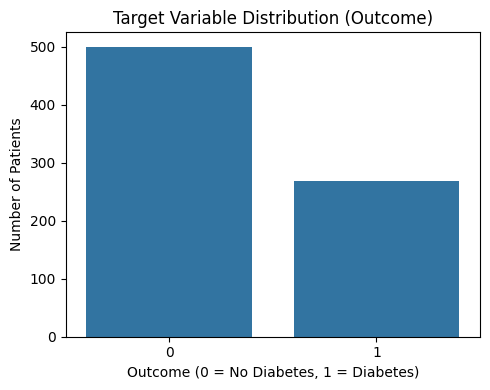

In [4]:
# =========================================================
# Step 3 (EDA - Part 1): Target Variable Analysis
# =========================================================

import matplotlib.pyplot as plt
import seaborn as sns

# Count target classes
target_counts = df["Outcome"].value_counts().sort_index()

print("Target Class Counts:")
print(target_counts)

print("\nTarget Class Proportions:")
print((target_counts / target_counts.sum()).round(3))

# Visualization
plt.figure(figsize=(5, 4))
sns.countplot(x="Outcome", data=df)
plt.title("Target Variable Distribution (Outcome)")
plt.xlabel("Outcome (0 = No Diabetes, 1 = Diabetes)")
plt.ylabel("Number of Patients")
plt.tight_layout()
plt.show()


Invalid Zero Value Counts (Medically Impossible):

Glucose         ->   5 zeros (0.65%)
BloodPressure   ->  35 zeros (4.56%)
SkinThickness   -> 227 zeros (29.56%)
Insulin         -> 374 zeros (48.70%)
BMI             ->  11 zeros (1.43%)


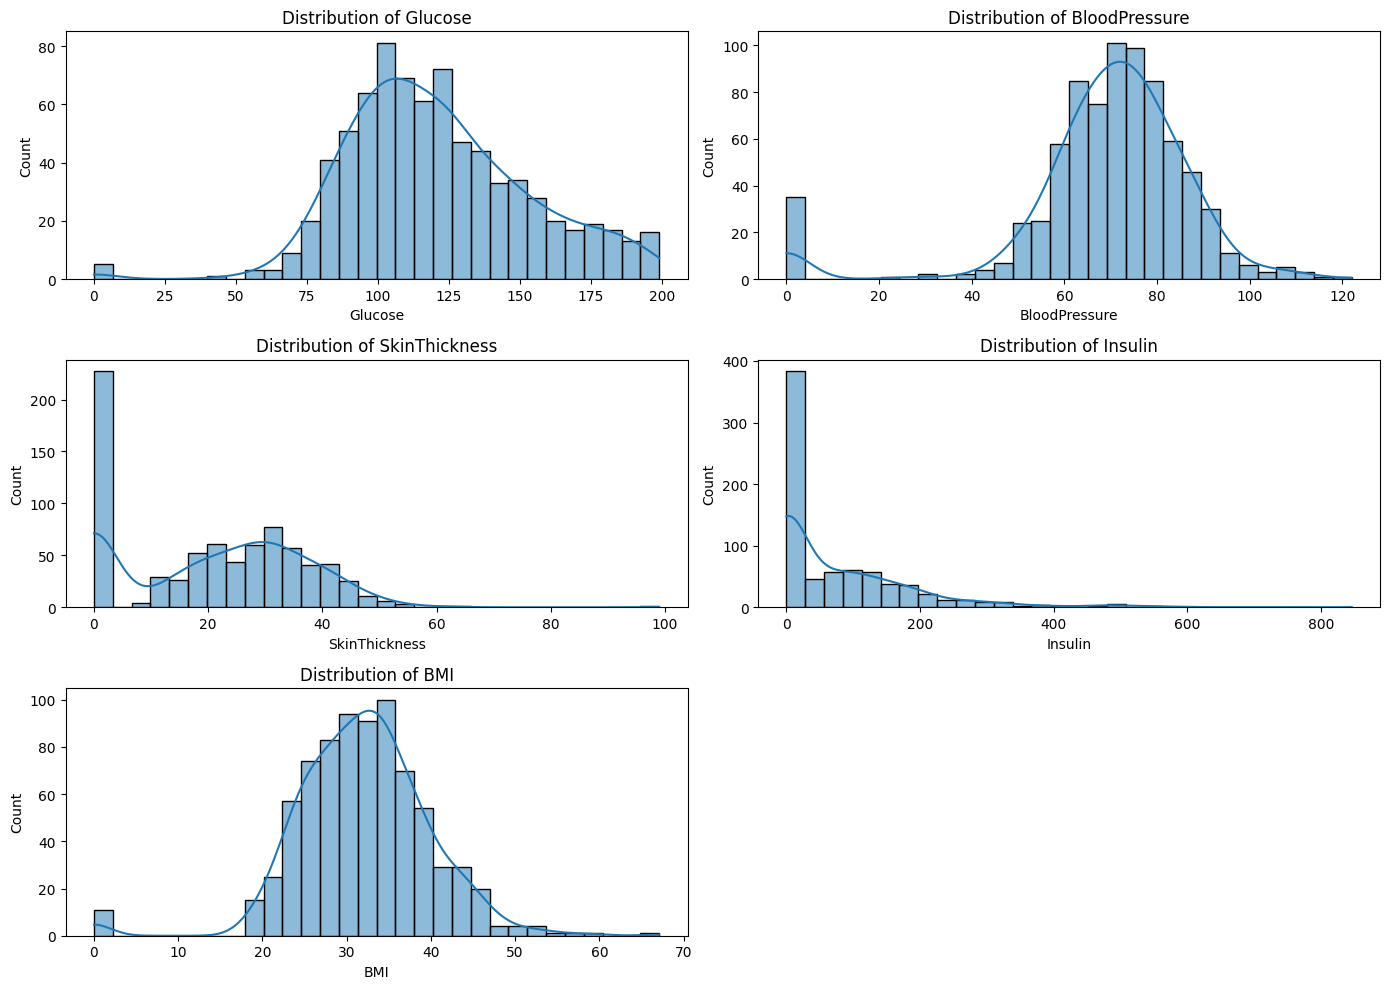

In [5]:
# =========================================================
# Step 3 (EDA - Part 2): Feature Distributions & Invalid Zeros
# =========================================================

# List of features that should not contain zero values
invalid_zero_features = [
    "Glucose",
    "BloodPressure",
    "SkinThickness",
    "Insulin",
    "BMI"
]

# Count zero values in each of these features
print("Invalid Zero Value Counts (Medically Impossible):\n")

for col in invalid_zero_features:
    zero_count = (df[col] == 0).sum()
    zero_percent = zero_count / len(df) * 100   # len(df) = 768 (No of recordings)
    print(f"{col:15s} -> {zero_count:3d} zeros ({zero_percent:.2f}%)")

# Visualize distributions to confirm the issue
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 10))

for i, col in enumerate(invalid_zero_features, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f"Distribution of {col}")

plt.tight_layout()
plt.show()


## Step 5: Data Cleaning Justification
#### Identified Issue

Exploratory Data Analysis revealed that several clinical features contain **zero values that are medically impossible** (e.g., Glucose = 0, BMI = 0). These values represent missing or **unrecorded measurements**, not valid medical observations.

#### Cleaning Strategy

* Medically invalid zero values were converted to *NaN*
* Missing values were imputed using the median of each feature

#### Rationale

* Median imputation is robust to skewed healthcare data
* Prevents distortion of feature distributions
* Preserves dataset size and medical validity

#### Outcome

This cleaning approach ensures the dataset is reliable, interpretable, and ready for **machine learning modeling** without introducing bias.

In [6]:
# =========================================================
# Step 5: Data Cleaning (Zero → NaN → Median Imputation)
# =========================================================

import numpy as np

# Features where zero is medically impossible
invalid_zero_features = [
    "Glucose",
    "BloodPressure",
    "SkinThickness",
    "Insulin",
    "BMI"
]

# Make a copy of the dataset to keep original data intact
df_clean = df.copy()

# Replace 0 with NaN for selected features
df_clean[invalid_zero_features] = df_clean[invalid_zero_features].replace(0, np.nan)

# Impute missing values using median (column-wise)
for col in invalid_zero_features:
    median_value = df_clean[col].median()
    df_clean[col] = df_clean[col].fillna(median_value)

# Verification: check remaining missing values
print("Missing values after cleaning:")
print(df_clean.isna().sum())

# Quick confirmation
df_clean[invalid_zero_features].describe().T


Missing values after cleaning:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


,count,mean,std,min,25%,50%,75%,max
Glucose,768.0,121.656250,30.438286,44.0,99.75,117.0,140.25,199.0
BloodPressure,768.0,72.386719,12.096642,24.0,64.00,72.0,80.00,122.0
SkinThickness,768.0,29.108073,8.791221,7.0,25.00,29.0,32.00,99.0
Insulin,768.0,140.671875,86.383060,14.0,121.50,125.0,127.25,846.0
BMI,768.0,32.455208,6.875177,18.2,27.50,32.3,36.60,67.1


```python
# Replace 0 with NaN for selected features
df_clean[invalid_zero_features] = df_clean[invalid_zero_features].replace(0, np.nan)

for col in invalid_zero_features:
    median_value = df_clean[col].median()
    df_clean[col].fillna(median_value, inplace=True)  # very import ==> inplace=True

OR


# Correct, safe, future-proof imputation
for col in invalid_zero_features:
    median_value = df_clean[col].median()
    df_clean[col] = df_clean[col].fillna(median_value)
```


# Step 6: Prepare Data for ML (Train/Test Split & Scaling)

In [7]:
# =========================================================
# Step 6: Prepare Data for ML (Train/Test Split & Scaling)
# =========================================================

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separate features and target
X = df_clean.drop("Outcome", axis=1)
y = df_clean["Outcome"]

# Train-test split (stratified to preserve class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

# Initialize scaler
scaler = StandardScaler()

# Fit scaler ONLY on training data, then transform both
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Confirmation
print("Training set shape:", X_train_scaled.shape)
print("Test set shape:", X_test_scaled.shape)
print("\nTarget distribution in training set:")
print(y_train.value_counts(normalize=True).round(3))


Training set shape: (614, 8)
Test set shape: (154, 8)

Target distribution in training set:
Outcome
0    0.651
1    0.349
Name: proportion, dtype: float64


# Step 7: Baseline Model - Logistic Regression

In [8]:
# =========================================================
# Step 7: Baseline Model - Logistic Regression
# =========================================================

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

# Initialize Logistic Regression model
log_reg = LogisticRegression(
    random_state=42,
    max_iter=1000
)

# Train the model
log_reg.fit(X_train_scaled, y_train)

# Predictions on test set
y_pred = log_reg.predict(X_test_scaled)

# Evaluation metrics
print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["No Diabetes", "Diabetes"]))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)


Accuracy: 0.708

Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.75      0.82      0.78       100
    Diabetes       0.60      0.50      0.55        54

    accuracy                           0.71       154
   macro avg       0.68      0.66      0.67       154
weighted avg       0.70      0.71      0.70       154

Confusion Matrix:
 [[82 18]
 [27 27]]


## Why Step 8 Is Needed After Step 7

* Logistic Regression is used as a baseline model to establish minimum performance.
* Baseline results show low recall for diabetic patients, which is critical in healthcare problems.
* Logistic Regression assumes linear relationships, limiting its ability to model complex clinical patterns.
* Healthcare data contains non-linear interactions between features (e.g., glucose, BMI, age).
* A more flexible model is required to improve detection of diabetic cases.
* Random Forest is introduced in Step 8 to capture non-linear relationships and improve model performance.

# Step 8: Train Random Forest Model

In [9]:
# =========================================================
# Step 8: Train Random Forest Model
# =========================================================

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

# Initialize Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

# Train the model
rf_model.fit(X_train, y_train)   # NOTE: unscaled features are used

# Predictions on test set
y_pred_rf = rf_model.predict(X_test)

# Evaluation metrics
print("Accuracy:", round(accuracy_score(y_test, y_pred_rf), 3))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=["No Diabetes", "Diabetes"]))

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix:\n", cm_rf)


Accuracy: 0.74

Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.78      0.84      0.81       100
    Diabetes       0.65      0.56      0.60        54

    accuracy                           0.74       154
   macro avg       0.71      0.70      0.70       154
weighted avg       0.73      0.74      0.73       154

Confusion Matrix:
 [[84 16]
 [24 30]]


# Step 9: Model Comparison & Final Decision
## Models Evaluated

* Logistic Regression (Baseline)
* Random Forest (Non-linear model)

## Performance Comparison

#### Logistic Regression
     * Accuracy ≈ 71%
     * Recall (Diabetes) = 0.50
     * Missed a high number of diabetic patients (high false negatives)
     * Limited by linear decision boundary

####  Random Forest
     * Accuracy = 74%
     * Recall (Diabetes) = 0.56
     * Detected more diabetic patients
     * Better handled non-linear relationships and feature interactions

## Key Decision Criteria

* Healthcare problems prioritize recall for positive cases
* Random Forest reduced false negatives compared to Logistic Regression
* Overall accuracy and F1-score also improved

## Final Model Selection

* **Random Forest is selected as the final model**
* Reason:
     * Higher accuracy
     * Improved recall for diabetic patients
     * Better suitability for non-linear healthcare data

# Conclusion
**Random Forest provides a more reliable and clinically relevant prediction performance than the baseline Logistic Regression model, making it the preferred choice for this diabetes prediction task.**

# Step 10: Feature Importance from Random Forest

In [10]:
# =========================================================
# Step 10: Feature Importance from Random Forest
# =========================================================

import pandas as pd

# Create a DataFrame of feature importance
feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf_model.feature_importances_
})

# Sort by importance
feature_importance = feature_importance.sort_values(
    by="Importance",
    ascending=False
).reset_index(drop=True)

# Display feature importance
feature_importance


,Feature,Importance
0,Glucose,0.268355
1,BMI,0.158066
2,DiabetesPedigreeFunction,0.124386
3,Age,0.120345
4,Insulin,0.092340
5,BloodPressure,0.083938
6,Pregnancies,0.079370
7,SkinThickness,0.073200


# Step 11: Interpretation of Feature Importance
## Key Observations

* Glucose is the most important feature, indicating strong association with diabetes risk.
* BMI ranks highly, reflecting the impact of body weight on diabetes.
* Age contributes significantly, showing increased risk with older age.
* Insulin provides additional predictive value related to insulin regulation.
* BloodPressure and SkinThickness have moderate influence.
* Pregnancies and DiabetesPedigreeFunction contribute less but still add useful context.

## Clinical Interpretation
* The model prioritizes clinically meaningful variables, aligning with medical knowledge.
* High-importance features are directly related to glucose metabolism and obesity, which are well-known diabetes risk factors.

## Model Trustworthiness
* Feature importance results confirm that the Random Forest model is learning valid medical patterns rather than noise.
* This improves confidence in the model’s predictions and supports its use for healthcare analysis.

# Step 12: Final Conclusion & Future Work

## Project Summary
This project developed a machine learning model to predict diabetes using clinical features from the Pima Indians Diabetes Dataset. A structured workflow was followed, including data cleaning, exploratory analysis, baseline modeling, and non-linear model comparison.

## Final Model Decision
- Logistic Regression was used as a baseline but showed limited recall for diabetic patients.
- Random Forest achieved higher accuracy and improved recall for the diabetes class.
- **Random Forest was selected as the final model** due to its better performance on clinically important cases.

## Key Findings
- Glucose, BMI, Age, and Insulin were the most influential features.
- The model learned medically meaningful patterns aligned with domain knowledge.

## Limitations
- Dataset size is relatively small.
- Class imbalance still affects recall.
- No hyperparameter tuning was applied.

## Future Improvements
- Hyperparameter tuning (GridSearch / RandomSearch)
- Class imbalance handling (class_weight, SMOTE)
- Threshold optimization to improve recall
- Model explainability using SHAP
